In [1]:
import random
from deap import base, creator, tools, algorithms
import pickle
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

import multiprocessing

In [13]:
#load data
ds_name = "NNSeval-1249"

simp_path = f"/workspace/datasets/ds_labels/{ds_name}_simp_labels.pkl"        
src_path = f"/workspace/datasets/ds_labels/{ds_name}_src_labels.pkl"  

simp_labels = pickle.load(open(simp_path, "rb"))
src_labels= pickle.load(open(src_path, "rb"))

X , y = np.concatenate([simp_labels, src_labels]), np.array([0]*len(simp_labels) + [1]*len(src_labels))
print(X.shape)
print(y.shape)

(3582, 1249)
(3582,)


In [14]:
# datasets: list of datasets
# make_categorical_data: transform numeric -1, 0, 1 data to categorical data, for each dimension 2 new ones, 
#       one with either SIMP/NOT_SIMP and one for ABSTAIN
def load_data(datasets, make_categorical_data):
    KAT = ''
    if make_categorical_data:
        KAT = '_KAT'

    data_merged = []
    labels = []

    for d_s in datasets:
        simp_path = f"/workspace/datasets/ds_labels/{d_s}_simp_labels.pkl"        
        src_path = f"/workspace/datasets/ds_labels/{d_s}_src_labels.pkl"  

        simp_labels = pickle.load(open(simp_path, "rb"))
        src_labels = pickle.load(open(src_path, "rb")) 

        for entry in simp_labels:
            if make_categorical_data:
                new_ent = []
                for e in entry:
                    if e == -1:
                        new_ent.append(0)
                        new_ent.append(0)

                    if e == 0:
                        new_ent.append(1)
                        new_ent.append(0)

                    if e == 1:
                        new_ent.append(0)
                        new_ent.append(1)
                    
                data_merged.append(new_ent)
            else:
                data_merged.append(entry.tolist())

        for entry in src_labels:
            if make_categorical_data:
                new_ent = []
                for e in entry:
                    if e == -1:
                        new_ent.append(0)
                        new_ent.append(0)

                    if e == 0:
                        new_ent.append(1)
                        new_ent.append(0)

                    if e == 1:
                        new_ent.append(0)
                        new_ent.append(1)

                data_merged.append(new_ent)
            else:
                data_merged.append(entry.tolist())

        curr_lab = [0] * len(simp_labels) + [1] * len(simp_labels)
        labels = labels + curr_lab

    X, y = shuffle(data_merged, labels, random_state=42)
    X = np.array(X)
    y = np.array(y)
    return X, y, KAT

In [16]:
X, y, _ = load_data([ds_name], make_categorical_data=False)

In [17]:
print(X.shape)
print(y.shape)

(3582, 2498)
(3582,)


In [18]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

/usr/local/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.8/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [19]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [20]:
clf_rf = RandomForestClassifier(random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
from sklearn.model_selection import cross_val_score

In [21]:
def eval_dim_vec(individual):

    sel_indices = np.array(individual).nonzero()[0]
    can_X = np.take(X, sel_indices, axis=1)

    cv_scores = cross_val_score(clf_rf, can_X, y, cv=kfold)
    fitness = np.mean(cv_scores)
    return fitness,
     

In [22]:
toolbox.register("evaluate", eval_dim_vec)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)

In [25]:
def main():
    
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    pool = multiprocessing.Pool(processes=4)
    toolbox.register("map", pool.map)

    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

NNSeval-1249
gen	nevals	avg     	min     	max     
0  	100   	0.924912	0.916805	0.932999
1  	57    	0.928114	0.920441	0.935232
2  	67    	0.929783	0.920998	0.935232
3  	55    	0.931012	0.923786	0.935232
4  	55    	0.932145	0.923227	0.936628
5  	64    	0.932731	0.924066	0.936349
6  	59    	0.933306	0.927418	0.938583
7  	68    	0.933262	0.925183	0.940256
8  	63    	0.934054	0.926858	0.940256
9  	60    	0.934255	0.9263  	0.940256
10 	55    	0.934612	0.925742	0.940256
Best individual is: [1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 

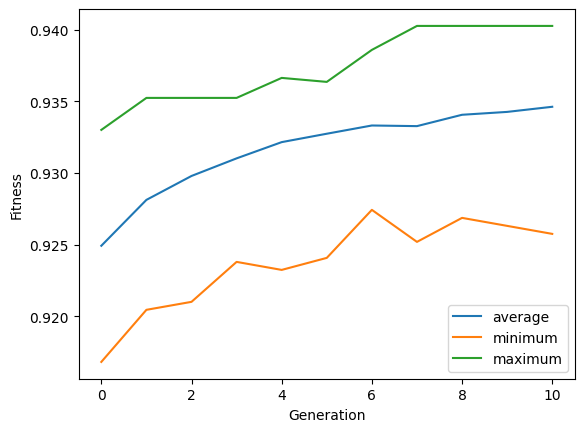

In [26]:
if __name__ == "__main__":
    print(ds_name)
    pop, log, hof = main()
    print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
    
    import matplotlib.pyplot as plt
    gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
    plt.plot(gen, avg, label="average")
    plt.plot(gen, min_, label="minimum")
    plt.plot(gen, max_, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="lower right")
    plt.show()

In [28]:
opt_lfs_path = f"/workspace/datasets/gen_opt_lfs/{ds_name}_lfs.pkl"

In [30]:
pickle.dump(np.array(hof[0]), open(opt_lfs_path, "wb"))

In [ ]:
hof[0]

In [31]:
pickle.load(open(opt_lfs_path, "rb"))

array([1, 1, 0, ..., 0, 0, 1])